# Biodiversity Intactness Index Change in Phoenix Subdivision
- by Ryan Green
- GitHub Repository: https://github.com/ryangreen6/BII_Index_Change

### About

- Purpose: 

Maricopa County, which includes the Phoenix metropolitan area, was recognized in 2021 as the county experiencing the most significant increase in developed land in the country since 2001. The rapid urban development in Maricopa County has had far-reaching consequences for the biodiversity and health of the surrounding area. In this workflow, we will use a dataset that measures the Biodiversity Intactness Index (BII) to analyze the change in biodiversity within the Phoenix Subdivision between 2017 and 2020, with the goal of identifying how urban growth has influenced biodiversity in the region. 

- Highlights:

This notebook explores the change in BII by using a shapefile of the Phoenix Subdivision and BII data for the region. The workflow involves basic manipulation and plotting of shapefiles, importing and manipulating data from Microsoft's Planetary Computer, finding differences in raster data through algebra, and mapping spatial data. 

- About the data:

Two major datasets are used in this workflow:
- US Census TIGER/Line Shapefiles database. The US Census keeps updated datasets on many geographic divisions throughout the country, and in this workflow we will use the shapefile for County Subidivisions in Arizona.

- BII Index Data. This data comes from Microsoft Planetary Computer's STAC Catalog, and was generated by Impact Observatory. 

References and Data Sources:
- U.S. Census Bureau. (October 9, 2024). TIGER/Line Shapefiles. Retrieved December 2, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
- Microsoft Planetary Computer. (n.d.). Biodiversity indicators dataset. Retrieved December 7, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity
- MEDS EDS 220. (n.d.). Final project. Retrieved December 7, 2024, from https://meds-eds-220.github.io/MEDS-eds-220-course/assignments/final-project.html

Loading necessary packages

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import geopandas as gpd
import rioxarray as rioxr
import contextily as cx
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

## Phoenix Subdivison Shapefile
In this first step, we will read in the shapefile for the Phoenix Subdivision. This shapefile will be the basis for all of our code and calculations through this workflow. 
This shapefile includes all county subdivisions in the state of Arizona. We will narrow it down to the Phoenix subdivision in the same step:

<Axes: >

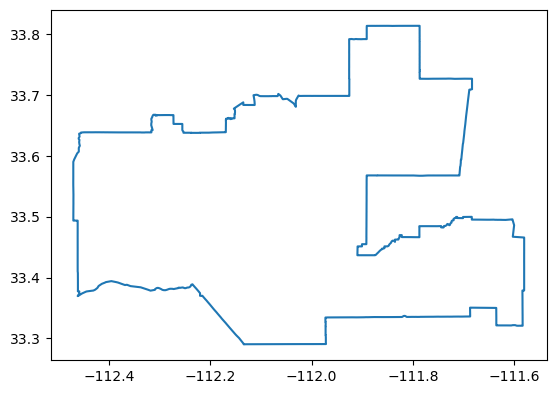

In [2]:
az = gpd.read_file("data/tl_2024_04_cousub.shp") # Reading in a shapefile 

phoenix = az[az["NAME"] == "Phoenix"] # Filtering the data to the Phoenix Subdivision

phoenix.boundary.plot() # Plotting the boundary of the Phoenix Subdivision for visiual reference

We will also plot the Phoenix Subdivision in its greater geographic context for reference. Here we have plotted the boudnary of the Subdivision over a basemap sourced through the package `contextily`, more specifically a basemap from OpenStreetMap. 

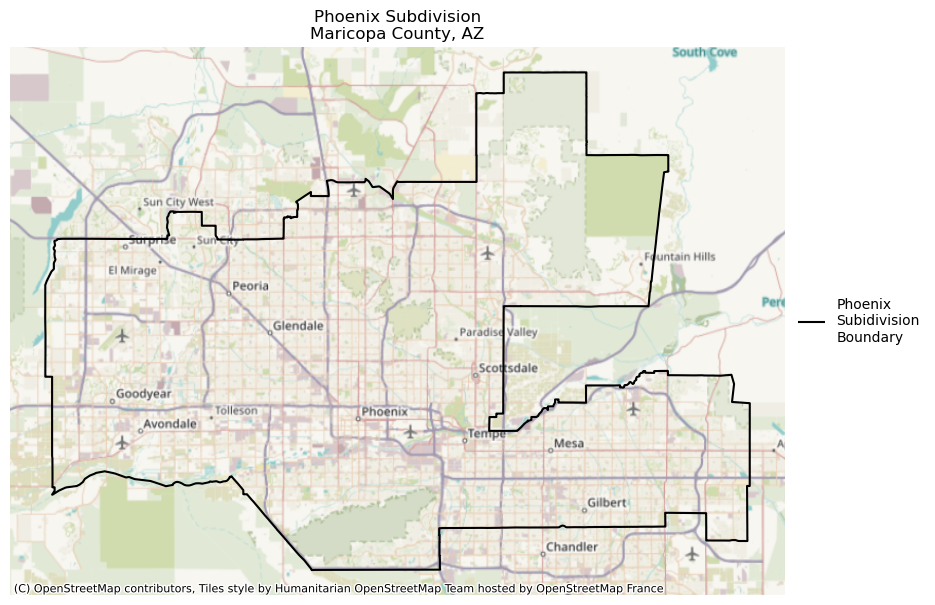

In [3]:
fig, ax = plt.subplots(figsize=(10, 8)) # Establishing figure and figure size

phoenix.boundary.plot(ax=ax, color = 'black', label = "Phoenix\nSubidivision\nBoundary") # Plotting Phoenix Subdivison boundary

cx.add_basemap(ax=ax, crs = phoenix.crs) # Plotting OpenStreetMap basemap

ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    frameon=False
)

ax.set_title('Phoenix Subdivision\nMaricopa County, AZ') # Setting title
ax.axis('off') # Removing axes 
plt.show()

## Biodiversity Intactness Index (BII) Data Retrieval
In the following steps, we will retrieve the BII for the Phoenix Subdivision from Microsoft's Planetary Computer. This data can be pulled from the internet directly into Python using the package `planetary_computer`, which we imported at the beginning of this workflow. 

In [4]:
phoenix_bbox = list([-112.826843, 32.974108, -111.184387, 33.863574]) # Establishing the bounding box for the Phoenix Subdivision, to tell Planetary Computer which data we want

catalog = pystac_client.Client.open( 
    "https://planetarycomputer.microsoft.com/api/stac/v1", # Opening Planetary Computer
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections = ['io-biodiversity'], # Searching Planetary Computer's catalog using the collection ID `io-biodiversity`, within the Phoneix Subdivision bounding box
                       bbox = phoenix_bbox)
search # Showing the retrieved object

Open the retrieved item:

In [5]:
items = search.item_collection() # Opening the item and assigning it to the variable `items`
print(f"Returned {len(items)} Items") # Using an f" string to print how many items were retrieved
items # Showing the objects

Returned 4 Items


Here, Planetary Computer has retrieved four items for BII within the Phoenix Subdivison. Navigating through each item and looking at their properties, each indexed item refers to a year of data. In our case, we want the years 2017 and 2020. The data for 2017 has index 3, and 2020 has index 0. Each year's data is an `xarray.DataArray` raster object, which contains multiple color bands and spatial reference data. These `DataArray`s can be opened using the package `rioxarray`:


In [6]:
item2017 = items[3] # Pulling index [3] and assigning it to the 2017 variable

BII2017 = rioxr.open_rasterio(item2017.assets['data'].href) # Opening `item2017` and assigning it to the variable `BII2017`, which we will carry through the rest of the workflow
BII2017 # Showing the object to understand its contents

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

And we will do the same for the 2020 data, index 0:

In [7]:
item2020 = items[0]

BII2020 = rioxr.open_rasterio(item2020.assets['data'].href)
BII2020

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## Change in BII
In this workflow we want to identify the change in BII within the Phoenix Subdivison between 2017 and 2020. Now that we have the data for both years, we can easily find this change through subtraction! But first we must wrangle the data a little more. 

These `xarrayDataArrays` have a third dimension, containg multiple light wavelengths outside the visible spectrum. This dimension is called `band`, referring to the other light wavelengths (or color bands). First we need to drop this third dimension to be able to plot them using `.squeeze`, and then clip the data to the Phoenix Subdivison object `phoenix`. After these steps, our data should be two-dimensional spatial data, within the Phoenix Subdivision. 

Below, you can see the extent of the BII item for 2017 that we retrieved. This is much more data than necessary, and why we need to clip it by the Phoenix Subdivision. 

In [8]:
Image(url = item2017.assets['rendered_preview'].href, width = 600)

Now we will perform these steps for the 2017 and 2020 data:

In [9]:
BII2017 = BII2017.squeeze().drop_vars('band') # Using `.squeeze` to compress the data, and `.drop_vars` to drop all variables of the `band` dimension

BII2017 = (BII2017.rio.clip_box(*phoenix.total_bounds) # Clipping the data to the Phoenix Subdivision
              .rio.clip(phoenix.geometry))

In [10]:
BII2020 = BII2020.squeeze().drop_vars('band')

BII2020 = (BII2020.rio.clip_box(*phoenix.total_bounds)
              .rio.clip(phoenix.geometry))

To identify significant change in BII in the Phoenix Subdivision, we will investigate only changes in BII above 0.75. For context, this means that these areas have 75% of their biodiversity intact. This can be done simply by filtering out any data below 0.75. Additionally, this step will create NA values for anything below .75, and so we will reassign any NA values to 0. 

In [11]:
BII2020_75 = BII2020 >= 0.75 # Including only data above .75 for both years
BII2017_75 = BII2017 >= 0.75

BII2017_75 = BII2017_75.fillna(0) # Assigning any NA values to 0
BII2020_75 = BII2020_75.fillna(0)

Here is the BII data for 2020, as an example of the rasters we are working with. 

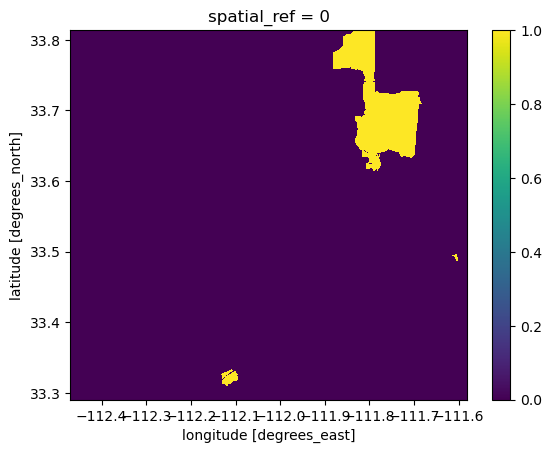

In [12]:
BII2020_75.plot()

Now we can perform the subtraction. In this step, we will also assign the object `diff` to values where the change was equal to 1, identifying areas where the BII of .75 changed between both rasters.

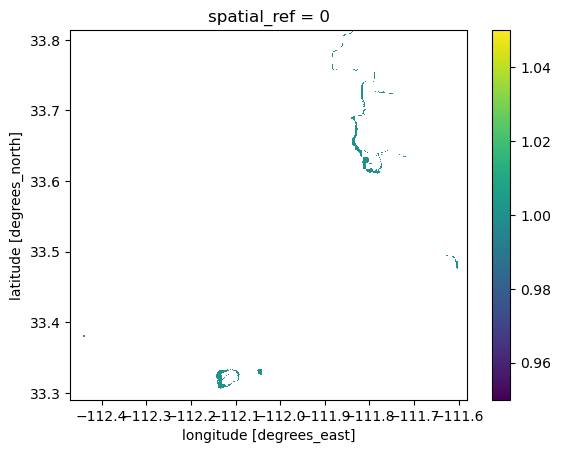

In [13]:
diff = BII2017_75 - BII2020_75 # Subtracting rasters

diff = diff.where(diff == 1) # Identifying changed areas

diff.plot() # Plotting to show the object

## Calculating the Percent Land Area Change
Now we have visualized the change in BII in the Phoenix Subdivision, but it is unclear exactly how much of the area has changed. In the following steps we can calculate the percentage of the subdivision where BII changed. 

To do this, we need to find the total area within the subdivision. Since we clipped both rasters for 2017 and 2020, we can take one of them and find the number of pixels above 0 (as only values within the subdivision have values above 0). We will also do this for both the `BII2017_75` and `BII2020_75` rasters, finding the area of each raster that has a BII of over .75. We will then assign these pixel counts to dataframes, where we can do basic algebra on the values, using their index locations within the dataframe.

In [14]:
total_pixels = BII2020 > 0 # Finding total pixels within the Phoenix Subdivision

values, counts = np.unique(total_pixels, return_counts = True) # Counting pixels
assert len(values) == len(counts) # Using `assert` to confirm that the length of values and counts is the same

x = {'values': values, 'counts': counts} # Assigning a dataframe with this total pixel count
pixels = pd.DataFrame(data = x)

print(f"There are {pixels.loc[1, 'counts']} pixels within the Phoenix Subdivision.") # Printing result

There are 338700 pixels within the Phoenix Subdivision.


In [15]:
values, counts = np.unique(BII2017_75, return_counts = True) # Finding the pixel counts in 2017
assert len(values) == len(counts)

_17 = {'values': values, 'counts': counts} # Assigning a dataframe with the 2017 pixel count
BII2017_75pix = pd.DataFrame(data = _17)

print(f"There are {BII2017_75pix.loc[1, 'counts']} pixels with BII > .75 in 2017.") # Printing result

There are 24133 pixels with BII > .75 in 2017.


In [16]:
values, counts = np.unique(BII2020_75, return_counts = True) # Finding the pixel counts in 2020
assert len(values) == len(counts)

_20 = {'values': values, 'counts': counts} # Assigning a dataframe with the 2020 pixel count
BII2020_75pix = pd.DataFrame(data = _20)

print(f"There are {BII2020_75pix.loc[1, 'counts']} pixels with BII > .75 in 2020.") # Printing result

There are 21986 pixels with BII > .75 in 2020.


In [17]:
pct_2017 = (BII2017_75pix.iloc[1,1] / pixels.iloc[1,1]) * 100 # Using algebra to divide each year by the total pixel count and find a percentage
pct_2020 = (BII2020_75pix.iloc[1,1] / pixels.iloc[1,1]) * 100

pct_change = pct_2017 - pct_2020

print(f"In 2017, {pct_2017:.2f}% of the Phoenix Subdivision had BII > .75.") # Printing results
print(f"In 2020, {pct_2020:.2f}% of the Phoenix Subdivision had BII > .75.")
print(f"The total percent change was {pct_change:.2f}%")

In 2017, 7.13% of the Phoenix Subdivision had BII > .75.
In 2020, 6.49% of the Phoenix Subdivision had BII > .75.
The total percent change was 0.63%


Here we can see the results of our calculations, showing the slow but significant growth of urban delevopment in the Phoenix Subdivision. 

## Mapping BII Change Between 2017 and 2020

With the data we collected throughout this workflow, we can create a map showing exactly which areas of the Phoenix Subdivision lost BII values of >.75. This helps visualize the change over time. For this map, we will overlay the change in BII raster, `diff`, over the BII raster for the entire subdivision in 2020. 

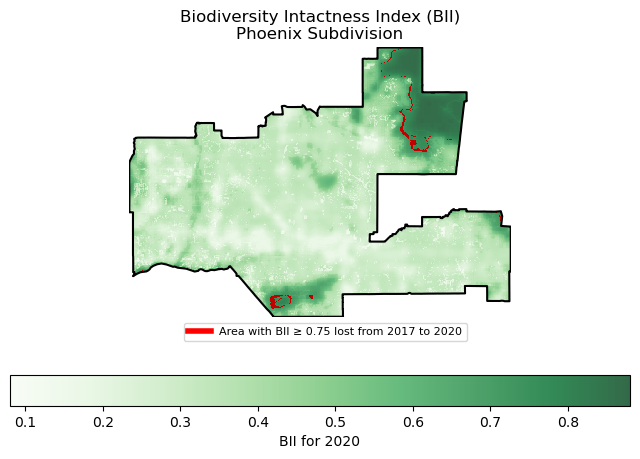

In [18]:
fig, ax = plt.subplots(figsize=(8, 5)) # Establish figure 


BII2020.plot(ax=ax, 
             cmap='Greens', 
             alpha=0.8,
             cbar_kwargs={'orientation': 'horizontal', # Plot BII 2020 raster
                         'label': 'BII for 2020'})

phoenix.boundary.plot(ax=ax, 
                      color = 'black') # Plot Phoenix Subdivision boundary

diff.plot(ax=ax, 
          cmap = 'gist_heat', 
          linewidths=0.5, add_colorbar = False) # Plot difference in BII raster

red_patch = mlines.Line2D([], [], 
                          color='red', 
                          label='Area with BII ≥ 0.75 lost from 2017 to 2020',  # Add red patch for legend
                          linewidth=4)

ax.legend(handles=[red_patch], 
          bbox_to_anchor = (0, 0, 0.9, 0), # Add legend
          fontsize=8)

ax.set_title('Biodiversity Intactness Index (BII)\nPhoenix Subdivision') # Add title
ax.axis('off')
plt.show()

Thank you for joining me in this exploration of BII change! 